In [1770]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
import json
import random

In [1764]:
DATA_FNAME = 'mnist_traindata.hdf5'
data = h5py.File(DATA_FNAME, 'r+')

xdata = data['xdata'][:] #60_000x784
ydata = data['ydata'][:] #60_000X10

train_xdata = xdata[0:50_000]
train_ydata = ydata[0:50_000]

test_xdata = xdata[50_000:]
test_ydata = ydata[50_000:]

target = test_ydata.argmax(axis = 1)
target = 1*target # 6000x1

In [1765]:
# Hidden Layer activations:
def tanh(x):
    y = np.array(x)
    
    return (np.exp(y) - np.exp(-y)) / (np.exp(y) + np.exp(-y))

#deriv tanh
def deriv_tanh(x: np.array):
    return 1 - tanh(x)**2

#ReLU
def relu(x):
    zeroes = np.zeros_like(x)    
    return np.maximum(zeroes, x)

#deriv ReLU
def deriv_relu(x: np.array):
    derivative = np.zeros_like(x)
    
    # Set the derivative to 1 where x is greater than or equal to zero
    derivative[x > 0] = 1
    return derivative



np.repeat(3, 4)
array([3, 3, 3, 3])

x = np.array([[1,2],[3,4]])
np.repeat(x, 2)

array([1, 1, 2, 2, 3, 3, 4, 4])
np.repeat(x, 3, axis=1)

array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])
       
np.repeat(x, [1, 2], axis=0)
array([[1, 2],
       [3, 4],
       [3, 4]])

In [1766]:
# Softmax
def softmax(x):
    
    # Find max to normalize, will be 50000x1
    normalize_terms = np.max(x, axis=1)
    
    # Replicate to be 50000x10
    normalize_terms = normalize_terms[:, np.newaxis]
    normalize_mat = np.repeat(normalize_terms, x.shape[1], axis=1)
    
    # print("normalize_terms, normalize mat:")
    # print(normalize_terms)
    # print(normalize_mat)
    
    # print("after normaliztion:")
    # print(x - normalize_mat)
    
    # print(normalize_mat)
    
    # Subtract maxs to normalize each
    numerator = np.exp(x - normalize_mat)
    sum_vector = np.sum(np.exp(x - normalize_mat), axis=1)
    sum_vector = sum_vector[:, np.newaxis]
    sum_mat = np.repeat(sum_vector, x.shape[1], axis=1)
    
    denominator = sum_mat
    
    # print("numerator")
    # print(numerator)
    
    # print("denominator")
    # print(denominator)
    
    return (numerator / denominator)

def one_hot(x):
    # Takes output of softmax, 50000x10
    # Convert to one-hot for each of the tens
    
    indices = np.argmax(x, axis=1)
    x[indices]

In [1767]:
# Softmax testbed
from scipy.special import softmax as sftmax

sample_data = np.array([
    [100000.0, 200000.0, 300000.0],
    [500000.0, 600000.0, 700000.0]
    ])
# Compute softmax using your function
softmax_output = softmax(sample_data)
print("My Softmax Output:")
print(softmax_output)
# Compare with NumPy softmax
numpy_softmax = sftmax(sample_data, axis=1)  # Replace with NumPy softmax function
print("SciPy Softmax Output:")
print(numpy_softmax)

# Check if your softmax matches NumPy softmax within a tolerance
tolerance = 1e-6
match = np.allclose(softmax_output, numpy_softmax, rtol=tolerance)
print("Match:", match)

My Softmax Output:
[[0. 0. 1.]
 [0. 0. 1.]]
SciPy Softmax Output:
[[0. 0. 1.]
 [0. 0. 1.]]
Match: True


In [1768]:
# Parameter Initialization
class MLP:
    def __init__(self):
        # 2 hidden, 1 output
        
        def xavier_normal_initialization(n, m):
            std = 2 / (n + m)
            return np.random.normal(0, std, (n, m))
        
        # Normal Initialization
        self.w1 = np.random.normal(size=(784, 200))
        self.w2 = np.random.normal(size=(200, 300))
        self.w3 = np.random.normal(size=(300,10))
        
        # Xavier Normal Initialization
        # self.w1 = xavier_normal_initialization(784, 200)
        # self.w2 = xavier_normal_initialization(200,300)
        # self.w3 = xavier_normal_initialization(300,10)
        
        
        self.b1 = np.zeros((1, 200))
        self.b2 = np.zeros((1, 300))
        self.b3 = np.zeros((1,10))
    
    # Probability
    def prob(x, w, w_0):
        probabilities = np.empty((x.shape[0], 1))
        
        probabilities = 1 / (1 + np.exp(-(np.dot(x, w) + w_0)))
        
        return probabilities
        
    # FeedForward
    def feedforward(self, x):
        # x Xx784 * w1 784x200 = Xx200
        a1 = relu(np.matmul(x, self.w1) + self.b1)
        
        # a1 Xx200 * w2 200x300 = Xx300
        a2 = relu(np.matmul(a1, self.w2) + self.b2)
        
        # a2 Xx300 * w3 300x10 = Xx10
        output_pre = (np.matmul(a2, self.w3) + self.b3)
        # print(output_pre)
        
        output = softmax(output_pre)
        
        return [a1, a2, output]
    
    # Cross-Entropy Loss
    def cross_loss(self, x, target):    
        
        target = target.argmax(axis = 1)
        target = 1*target
        
        y = target

        return -np.sum(y * np.log(softmax(x) + 10e-10)) / len(x)
        
    # Backprop
    def back_prop(self, x_data, y_data, ff_out, learning_rate):
        batch_size = 100
        
        #a1, a2, output = ff_out
        
        # Iterate Epoch
        for epoch in range(50):
            # Iterate Batch with SGD
            # need to average gradients for weights and bias over each minibatch
            #for index in range(0, len(x), batch_size):
            stochastic_start = random.randint(0, len(x_data))
            for index in range(0, len(x_data), batch_size):    
                batch_end_index = min(index + batch_size, len(x_data))
                x = x_data[index : batch_end_index]
                y = y_data[index : batch_end_index]
                
                # Feed Forward for current batch
                a1, a2, output = self.feedforward(x)
                
                # Question: How is delta affected by batching?
                # accuracy, loss, gradients_dict
                
                # Update Weights and Bias here
                
                # For Initial delta, delta = a - y given a is one-hot
                
                #Xx10
                # print("output shape", output.shape)
                # print("y shape", y.shape)
                delta_3 = (output - y).T
                # print("delta3 shape", delta_3.shape)
                #batch_delta_3.append(delta_3)
                
                # Recursively compute other deltas using derivative of activation
                delta_2 = deriv_relu(a2.T) * np.matmul(self.w3, delta_3)
                # print(delta_2.shape)
                #batch_delta_2.append(delta_2)
                
                delta_1 = deriv_relu(a1.T) * np.matmul(self.w2, delta_2)
                # print("a1 shape", a1.shape)
                # print("w2 shape", self.w2.shape)
                # print("delta2 shape", delta_2.shape)
                # print(delta_1.shape)
                #batch_delta_1.append(delta_1)
                    
                # Average gradients for weight and bias updates over each minibatch
                avg_delta_3 = np.mean(delta_3) * np.ones_like(delta_3)
                avg_delta_2 = np.mean(delta_2) * np.ones_like(delta_2)
                avg_delta_1 = np.mean(delta_1) * np.ones_like(delta_1)
                
                # Weight calculation: weight - learning rate * delta * a (output of previous layer)
                
                #w3 is 300x10
                self.w3 -= learning_rate * (np.matmul(avg_delta_3, a2)).T
                self.w2 -= learning_rate * (np.matmul(avg_delta_2, a1)).T
                self.w1 -= learning_rate * (np.matmul(avg_delta_1, x)).T
                
                # deltas for biases need different dims
                avg_delta_b_3 = np.mean(delta_3) * np.ones_like(self.b3)
                avg_delta_b_2 = np.mean(delta_2) * np.ones_like(self.b2)
                avg_delta_b_1 = np.mean(delta_1) * np.ones_like(self.b1)
                
                self.b3 -= learning_rate * avg_delta_b_3
                self.b2 -= learning_rate * avg_delta_b_2
                self.b1 -= learning_rate * avg_delta_b_1

            # Half learning rate after epochs 20 and 40
            if epoch % 20:
                learning_rate /= 2
            
            # At the end of each epoch, complete a forward pass with the validation set and record the accuracy
            validation_pass =  self.feedforward(test_xdata)[2].argmax(axis = 1)
            #print(validation_pass.shape)
            #epoch_loss = self.cross_loss(validation_pass, test_ydata)
            #print("epoch loss was:", epoch_loss)
            
            # record accuracy
            #accuracy = target - validation_pass
            print("Accuracy is:")
            target = test_ydata.argmax(axis = 1)
            target = 1*target # 6000x1
            
            # count = 0
            # for i in range(len(target)):
            #     if validation_pass[i] == target[i]:
            #         count +=1
            
            # print(count)
            
            accuracy = np.equal(target, validation_pass)
            print(np.sum(accuracy*1))
                    
            
            
            
            # check loss of training set after each epoch, take average of loss for all batches, print
            
            
            # Another feedforward before your next epoch
        
        # epoch loop ends here


In [1769]:
# Testing block for feedforawrd
nnet = MLP()
ff_out = nnet.feedforward(train_xdata)
nnet.back_prop(train_xdata, train_ydata, ff_out, .01)

KeyboardInterrupt: 

In [ ]:
for i in np.argmax(ff_out[2], axis=1):
    print(i)


5
5
5
5
5
1
5
5
5
1
5
1
5
5
5
5
5
5
5
1
5
5
1
5
5
5
1
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
1
5
1
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
1
1
5
5
5
5
5
5
5
5
5
5
1
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
1
4
5
5
5
5
5
5
5
0
5
1
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
1
5
5
1
5
5
5
5
5
5
5
5
5
8
1
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
1
5
5
5
1
5
5
5
5
5
5
5
5
5
1
5
1
5
5
5
1
5
1
1
5
5
1
5
5
1
1
5
5
5
5
5
1
5
5
5
5
5
5
5
1
5
5
5
1
5
1
5
5
5
1
5
5
1
5
1
5
1
5
5
1
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5
5
5
5
1
1
5
5
5
5
1
1
5
5
1
5
1
1
5
5
5
5
1
5
5
1
5
5
5
5
5
5
5
1
5
1
5
1
5
5


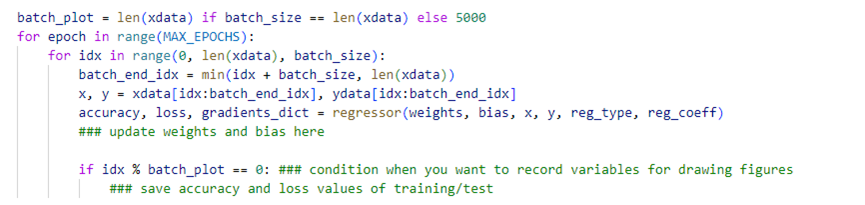

        # p_x = self.prob(x, self.w1, self.b1)
        # grad_z = p_x - target
        
        # gradients_dict = {}
        
        # gradients_dict['grad_bias'] = -(np.sum((p_x)*(1-p_x)*(1)))/len(x)
        
        # gradients_dict['grad_weights'] = np.dot(x.transpose(), grad_z)/len(x) + ((np.linalg.norm(w)**2)*reg_coeff)/len(x)
        
        # self.w1 = self.w1 - learning_rate * gradients_dict['grad_weights']
        # self.b1 = self.b1 - learning_rate * gradients_dict['grad_bias']

In [ ]:
# Try training